#**Final Report**





# Introducción:
La industria aérea es altamente competitiva, donde la experiencia del cliente juega un rol central en la retención y fidelización. United Airlines enfrenta importantes desafíos para destacar frente a sus competidores, especialmente en áreas relacionadas con la percepción de valor y satisfacción general. Este análisis tiene como objetivo identificar segmentos de clientes, detectar factores críticos que impactan la experiencia y desarrollar estrategias basadas en datos para mejorar la posición competitiva de United.

Para lograrlo, se utilizó un enfoque combinado de:

1. Análisis de sentimientos basado en reseñas y analisis de topicos

2. Segmentación de clientes mediante clustering.

3. Creación de un modelo predictivo para determinar los factores que afectan la recomendación del servicio.
5. métricas para detectar las áreas críticas y proponer acciones específicas.

Este trabajo no solo proporciona una visión detallada de las fortalezas y debilidades de United, sino que también establece una hoja de ruta para mejorar su desempeño y percepción entre los clientes.


## Carga y Preprocesamiento de Datos

In [1]:
import pandas as pd
import numpy as np
import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Instalar nltk
!pip install --quiet nltk

# Importar y descargar recursos necesarios
import nltk
nltk.download('vader_lexicon')  # Para análisis de sentimientos
nltk.download('punkt')          # Para tokenización
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.nn.functional import softmax
from tqdm import tqdm


# Cargar el modelo BERT especializado para análisis de sentimientos
from transformers import AutoTokenizer, AutoModelForSequenceClassification

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
pip install pandas numpy scikit-learn xgboost transformers

In [3]:
df = pd.read_csv('/content/balanced_airline_reviews.csv')
df.shape

(17150, 34)

1. Selección del Tipo de Modelo

Modelos Desarrollados:

Se han desarrollado varios modelos para abordar diferentes aspectos del problema:


1. Análisis de Sentimientos

2. Clasificación binaria: Regresión Logística y Random Forest para predecir si un cliente recomendaría o no el servicio de United Airways. Este modelo es ideal para optimizar estrategias de marketing y mejorar la experiencia del cliente.

3. Segmentación de Clientes: Clustering mediante K-Means para identificar segmentos de usuarios según sus preferencias y experiencias.

Cada modelo cumple un propósito específico para enriquecer la visión integral de los datos y tomar decisiones estratégicas.

# Modelo Predictivo: Construcción del modelo y sus resultados.

##  Preparación de datos

In [4]:
 # Verificar columnas existentes
columns_to_dummy = [col for col in [
    'traveller_type', 'cabin', 'airport_classification_origin',
    'airport_classification_destin', 'continent_origin', 'continent_destin'
] if col in df.columns]

# Generar variables dummies solo para las columnas que existen y asegurarse de que sean 0 y 1
if columns_to_dummy:
    df = pd.get_dummies(df, columns=columns_to_dummy, drop_first=True)
    # Convertir todas las columnas generadas por dummies a int
    dummy_columns = [col for col in df.columns if any(prefix in col for prefix in columns_to_dummy)]
    df[dummy_columns] = df[dummy_columns].astype(int)
else:
    print("Ninguna de las columnas especificadas existe en el DataFrame.")

In [5]:
def clean_text(text):
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'[^\w\s]', '', text)  # Quitar puntuación
    return text

df['customer_review'] = df['customer_review'].apply(clean_text)

In [6]:
# Target Encoding para la columna 'airline'
airline_target_mean = df.groupby('airline')['recommended'].mean()
df['airline_encoded'] = df['airline'].map(airline_target_mean)

# Frequency Encoding para códigos IATA
for col in ['iata_code_origin', 'iata_code_destination']:
    freq = df[col].value_counts() / len(df)
    df[col + '_encoded'] = df[col].map(freq)

df = df.drop(['iata_code_origin'], axis=1)
df = df.drop(['iata_code_destination'], axis=1)
df.drop('airline', axis=1, inplace=True)

In [7]:
frequency_columns = ['municipality_origin', 'municipality_destin']

# Aplicar Frequency Encoding a cada columna de la lista
for col in frequency_columns:
    # Calcular la frecuencia de cada categoría
    freq = df[col].value_counts() / len(df)
    # Mapear la frecuencia en la columna original
    df[col + '_encoded'] = df[col].map(freq)

# Opcional: eliminar las columnas originales si ya no las necesitas
df.drop(frequency_columns, axis=1, inplace=True) # --> me gusta!

In [8]:
from scipy.stats import chi2_contingency

# Crear una tabla de contingencia entre 'recommended' y 'country_origin'
contingency_table = pd.crosstab(df['recommended'], df['country_origin'])

# Calcular la prueba de Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Origin:    Chi2: {chi2}, p-value: {p}")

# Crear una tabla de contingencia entre 'recommended' y 'country_destin'
contingency_table = pd.crosstab(df['recommended'], df['country_destin'])

# Calcular la prueba de Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Destin:    Chi2: {chi2}, p-value: {p}")

Origin:    Chi2: 463.5981416753651, p-value: 2.3897449484335697e-57
Destin:    Chi2: 375.6706690360036, p-value: 1.701619634136248e-39


In [9]:
frequency_columns = ['country_origin', 'country_destin']

# Aplicar Frequency Encoding a cada columna de la lista
for col in frequency_columns:
    # Calcular la frecuencia de cada categoría
    freq = df[col].value_counts() / len(df)
    # Mapear la frecuencia en la columna original
    df[col + '_encoded'] = df[col].map(freq)

# Opcional: eliminar las columnas originales si ya no son necesarias
df.drop(frequency_columns, axis=1, inplace=True)

In [10]:

df.drop(["coordinates_destin", "coordinates_origin"], axis=1, inplace=True)
df.drop('author', axis=1, inplace=True)
df = df.dropna()

## Baseline: regresión logistica

Selección del Tipo de Modelo

- Este modelo se utiliza como un baseline debido a su simplicidad y eficiencia. Al ser fácil de interpretar, sirve como punto de partida para comparar con modelos más complejos, permitiendo evaluar mejoras en el rendimiento en problemas de clasificación binaria.



In [11]:
df_reg_log= df.copy()

In [12]:
df_reg_log.drop('customer_review', axis=1, inplace=True)

### Selección de Características:

Todas las variables del dataset, excluyendo 'customer_review', se utilizarán para realizar la predicción, omitiendo temporalmente esta última variable.

Variables Numéricas (ya fueron transformadas en el paso anterior)

- overall
- review_dayofweek
- review_month
- review_year
- 'flight_dayofweek',
- 'flight_month',
- 'flight_year',
- days_since_flight

- seat_comfort
- cabin_service
- food_bev
- ground_service
- value_for_money
- route_distance
- route_time_minutes
- iata_code (origin y destin)
- municipality (origin y destin)
- country_encoded (origin y destin)
- recommended (target)

- traveller_type
- cabin
- airline
- airport classification (origin y destin)
- continent (origin y destin)



In [13]:
# Selección de características tradicionales (sin embeddings)
X = df_reg_log.drop(columns=['recommended'])
y = df_reg_log['recommended']

### División de Conjuntos de Datos

Proporciones:

- Entrenamiento: 70%
- Validación: 15%
- Prueba: 15%

La división asegura un conjunto de entrenamiento suficiente, permite ajustar hiperparámetros en validación y evalúa el rendimiento en datos no vistos.

In [14]:
# Dividir en conjuntos de entrenamiento, validación y prueba
from sklearn.model_selection import train_test_split

# Dividir en conjunto de entrenamiento y conjunto temporal (validación + prueba)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42  # El 30% será dividido entre validación y prueba
)

# Dividir el conjunto temporal en validación y prueba
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42  # Dividir el 30% en partes iguales
)

# Confirmar los tamaños de los conjuntos
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} filas")
print(f"Tamaño del conjunto de validación: {X_val.shape[0]} filas")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} filas")

Tamaño del conjunto de entrenamiento: 11986 filas
Tamaño del conjunto de validación: 2569 filas
Tamaño del conjunto de prueba: 2569 filas


### 4. Entrenamiento y Ajuste del Modelo
- **Técnicas Utilizadas:**
  - Entrenamiento en el conjunto de datos de entrenamiento (`X_train`, `y_train`) utilizando parámetros predeterminados del modelo de regresión logística (`max_iter=1000`).
  - Evaluación del modelo en los conjuntos de validación y prueba para medir su rendimiento con datos no vistos.


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Entrenar modelo con el conjunto de entrenamiento
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Evaluación en el conjunto de entrenamiento
y_pred_train = log_reg.predict(X_train)
print("Reporte de clasificación (entrenamiento):")
print(classification_report(y_train, y_pred_train))
print(f"Accuracy (entrenamiento): {accuracy_score(y_train, y_pred_train):.4f}")

# Evaluación en el conjunto de validación
y_pred_val = log_reg.predict(X_val)
print("\nReporte de clasificación (validación):")
print(classification_report(y_val, y_pred_val))
print(f"Accuracy (validación): {accuracy_score(y_val, y_pred_val):.4f}")

# Evaluación en el conjunto de prueba
y_pred_test = log_reg.predict(X_test)
print("\nReporte de clasificación (prueba):")
print(classification_report(y_test, y_pred_test))
print(f"Accuracy (prueba): {accuracy_score(y_test, y_pred_test):.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Reporte de clasificación (entrenamiento):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5991
           1       0.97      0.97      0.97      5995

    accuracy                           0.97     11986
   macro avg       0.97      0.97      0.97     11986
weighted avg       0.97      0.97      0.97     11986

Accuracy (entrenamiento): 0.9727

Reporte de clasificación (validación):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1265
           1       0.97      0.97      0.97      1304

    accuracy                           0.97      2569
   macro avg       0.97      0.97      0.97      2569
weighted avg       0.97      0.97      0.97      2569

Accuracy (validación): 0.9704

Reporte de clasificación (prueba):
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1302
           1       0.98      0.97      0.97      1267

 

**Evaluación del Modelo y Consistencia de los Resultados**

Los resultados obtenidos del modelo muestran una **consistencia alta** entre los tres conjuntos de datos: entrenamiento, validación y prueba. Las métricas clave como la **precisión**, **recall**, **f1-score** y **accuracy** son **similares** en las tres secciones, con valores cercanos a **0.97**, lo que indica que el modelo generaliza bien y no presenta signos de **overfitting**.

En el conjunto de entrenamiento, el modelo alcanza un **accuracy** de 97.27%, mientras que en los conjuntos de validación y prueba, el **accuracy** es de 97.04% y 97.08%, respectivamente. Esta consistencia en los resultados sugiere que el modelo no ha aprendido en exceso de los datos de entrenamiento, sino que tiene la capacidad de aplicar lo aprendido de manera efectiva en datos nuevos y no vistos.

El hecho de que las métricas de **precision**, **recall** y **f1-score** se mantengan casi iguales entre los tres conjuntos también refuerza la idea de que el modelo no está sesgado hacia los datos de entrenamiento, sino que puede predecir de manera sólida tanto en el conjunto de validación como en el conjunto de prueba.

### 5. Métricas de Evaluación

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score

# Calcular métricas adicionales para el conjunto de prueba
accuracy_logreg = accuracy_score(y_test, y_pred_test)
precision_logreg = precision_score(y_test, y_pred_test)
recall_logreg = recall_score(y_test, y_pred_test)
f1_logreg = f1_score(y_test, y_pred_test)
auc_logreg = roc_auc_score(y_test, y_pred_test)

# Imprimir métricas adicionales con redondeo a 4 decimales
print("\nRegresión Logística - Accuracy:", round(accuracy_logreg, 4))
print("Regresión Logística - Precision:", round(precision_logreg, 4))
print("Regresión Logística - Recall:", round(recall_logreg, 4))
print("Regresión Logística - F1 Score:", round(f1_logreg, 4))
print("Regresión Logística - AUC:", round(auc_logreg, 4))
print("_________________________________________________________\n")
print("Regresión Logística - Classification Report:\n", classification_report(y_test, y_pred_test, digits=3))



Regresión Logística - Accuracy: 0.9708
Regresión Logística - Precision: 0.9753
Regresión Logística - Recall: 0.9653
Regresión Logística - F1 Score: 0.9702
Regresión Logística - AUC: 0.9707
_________________________________________________________

Regresión Logística - Classification Report:
               precision    recall  f1-score   support

           0      0.967     0.976     0.971      1302
           1      0.975     0.965     0.970      1267

    accuracy                          0.971      2569
   macro avg      0.971     0.971     0.971      2569
weighted avg      0.971     0.971     0.971      2569



El modelo de **Regresión Logística** muestra un rendimiento sólido en la clasificación de las reseñas, con una **accuracy** de **97.08%** y una **precisión** de **97.53%**, lo que indica que el modelo es eficiente en la identificación correcta de las clases (clientes satisfechos e insatisfechos). La **recall** de **96.53%** y el **F1 score** de **97.02%** sugieren un buen balance entre la capacidad de identificar clientes insatisfechos (Clase 1) y clientes satisfechos (Clase 0), aunque con un ligero sesgo hacia la Clase 0 (clientes satisfechos).

**Matriz de Confusión**:

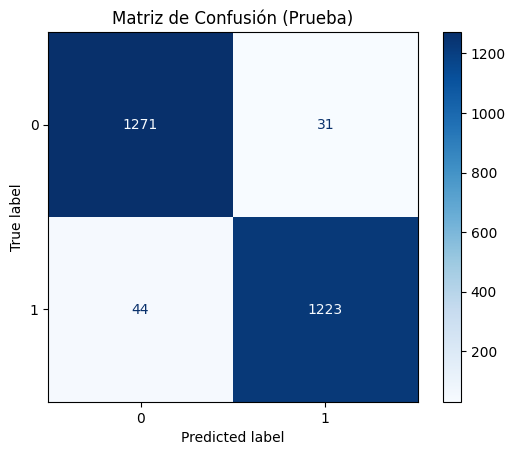

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Matriz de confusión para el conjunto de prueba
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=log_reg.classes_)
disp_test.plot(cmap='Blues')
plt.title("Matriz de Confusión (Prueba)")
plt.show()


- **Verdaderos positivos**: El modelo ha identificado correctamente a 1223 clientes satisfechos como "recomendadores", lo cual es positivo.
- **Verdaderos negativos**: También identificó correctamente a 1271 clientes insatisfechos como "no recomendadores".
- **Falsos positivos**: 31 clientes fueron clasificados incorrectamente como "satisfechos" cuando en realidad no lo estaban, lo cual es una pequeña cantidad y no parece problemático dado el total de clientes.
- **Falsos negativos**: 44 clientes fueron clasificados incorrectamente como "no recomendadores" cuando en realidad estaban satisfechos.

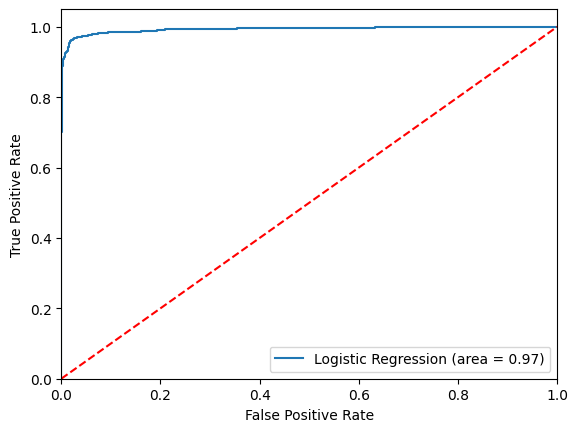

In [18]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

log_roc_auc = roc_auc_score(y_test, log_reg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % log_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

La Curva ROC muestra que el modelo tiene una buena capacidad para distinguir entre las clases, con un AUC de 0.97, lo que indica un rendimiento muy bueno. Esto sugiere que la Regresión Logística es muy eficaz en la clasificación, con una alta probabilidad de identificar correctamente los positivos frente a los negativos.

In [19]:
# Obtener los coeficientes del modelo y las columnas asociadas
coef = log_reg.coef_[0]  # Los coeficientes del modelo
features = X.columns  # Los nombres de las columnas (variables)

# Crear un DataFrame para facilitar el análisis
importance_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coef,
    'Absolute Coefficient': np.abs(coef)
})

# Ordenar por la magnitud de los coeficientes (absolutos)
importance_df = importance_df.sort_values(by='Absolute Coefficient', ascending=False)

importance_df

,Feature,Coefficient,Absolute Coefficient
13,value_for_money,1.092919,1.092919
0,overall,0.750874,0.750874
31,continent_destin_North America,-0.429247,0.429247
15,route_time_minutes,0.399289,0.399289
9,cabin_service,0.385724,0.385724
10,food_service,-0.369277,0.369277
29,continent_destin_Asia,0.345356,0.345356
12,ground_service,0.319837,0.319837
19,cabin_Economy Class,0.308978,0.308978
20,cabin_First Class,0.298000,0.298000


## Modelo XGBoost Classifier

### 1. Selección del Tipo de Modelo

El modelo XGBoost classifier es una buena opción porque puede manejar datos con muchas variables, tanto numéricas como categóricas. También es capaz de captar relaciones no lineales y complejas en los datos, lo cual lo hace muy efectivo para este tipo de problemas. Además, una de sus ventajas es que permite interpretar el modelo a través de las importancias de las características, lo que ayuda a identificar qué factores influyen más en la recomendación de los clientes.

### 2. Selección de Características


```
overall, review_dayofweek, review_month, review_year, flight_dayofweek, flight_month, flight_year, days_since_flight, seat_comfort, cabin_service,.
food_bev, ground_service,
value_for_money, route_distance, route_time_minutes, iata_code (origin y destin), municipality (origin y destin), country_encoded (origin y destin),
recommended (target), traveller_type, cabin, airline, airport classification (origin y destin), continent (origin y destin)

```




**+**

Embeddings de Texto:

- Los embeddings generados a partir de las reseñas de los clientes utilizando el modelo sentence-transformers/all-MiniLM-L6-v2, con reducción de dimensionalidad mediante PCA a 10 componentes principales.


El modelo **"sentence-transformers/all-MiniLM-L6-v2"** se elige por su eficiencia y capacidad para generar representaciones semánticas de alta calidad a partir de texto. Es más rápido que otros modelos más grandes como BERT, lo que lo hace adecuado para procesar grandes volúmenes de datos sin sacrificar demasiado rendimiento. Además, su implementación con **Hugging Face Transformers** permite usarlo de manera sencilla, obteniendo embeddings de oraciones que pueden ser utilizados en tareas como clasificación o comparación de similitud.

In [20]:
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm  # Para la barra de progreso

# Configurar tqdm para pandas
tqdm.pandas()

# Cargar el tokenizer y el modelo
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# Función para obtener el embedding de un texto
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [21]:
# Generar embeddings para todas las reseñas con barra de progreso
df['review_embedding'] = df['customer_review'].progress_apply(get_embedding)

100%|██████████| 17124/17124 [22:35<00:00, 12.63it/s]


In [22]:
from sklearn.decomposition import PCA

# Usar los embeddings del dataset original
embeddings_original = np.vstack(df['review_embedding'])  # Usa los embeddings de tu dataset original

# Entrenar PCA con el dataset original y reducir a 10 componentes
pca_original = PCA(n_components=10)
reduced_embeddings_original = pca_original.fit_transform(embeddings_original)

# Guardar los 10 componentes principales en el DataFrame
for i in range(10):
    df[f'review_embedding_{i}'] = reduced_embeddings_original[:, i]

# Eliminar la columna de embeddings completos para ahorrar memoria (opcional)
df.drop(columns=['review_embedding'], inplace=True)

Se utiliza PCA (Análisis de Componentes Principales) para reducir la dimensionalidad de los embeddings generados para las reseñas en el dataset. Primero, se extraen los embeddings originales de las reseñas, luego se ajusta un modelo PCA para reducir esos embeddings a 10 componentes principales. Después, se agregan estos componentes al dataframe como nuevas columnas. Finalmente, se elimina la columna original de embeddings completos para ahorrar memoria y a su vez tambien se elimina la varibale "customer_review". Este proceso facilita el manejo de datos de alta dimensión y mejora la eficiencia del modelo.

In [23]:
df.drop('customer_review', axis=1, inplace=True)

In [24]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['recommended'])
y = df['recommended']

In [25]:
# Convertir embeddings (listas/arrays) a columnas numéricas
if 'review_embedding' in X.columns:
    embeddings = np.vstack(X['review_embedding'])
    embeddings_df = pd.DataFrame(embeddings, index=X.index)
    X = X.drop(columns=['review_embedding']).join(embeddings_df)


### 3. División de Conjuntos de Datos

Proporciones:
- Entrenamiento: 70%
- Validación: 15%
- Prueba: 15%

Esta configuración asegura un conjunto suficientemente amplio para entrenar el modelo, permite ajustar hiperparámetros en validación y evaluar el rendimiento en datos no vistos.


In [26]:
from sklearn.model_selection import train_test_split

# Primera división: 70% entrenamiento, 30% restante para validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Segunda división: Divide el 30% restante en validación y prueba (15% y 15% del total original)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train.columns = X_train.columns.astype(str)
X_val.columns = X_val.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} filas")
print(f"Tamaño del conjunto de validación: {X_val.shape[0]} filas")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} filas")

Tamaño del conjunto de entrenamiento: 11986 filas
Tamaño del conjunto de validación: 2569 filas
Tamaño del conjunto de prueba: 2569 filas


### 4. Entrenamiento y Ajuste del Modelo

RandomizedSearchCV para optimizar un modelo XGBClassifier buscando la mejor combinación de hiperparámetros. Se definen rangos de valores para parámetros como n_estimators, max_depth, learning_rate, y regularización. El modelo se ajusta usando validación cruzada (cv=5) y la métrica AUC-ROC. Finalmente, se muestran los mejores parámetros encontrados y el mejor AUC score obtenido en la búsqueda.

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Definir un nuevo rango de hiperparámetros más enfocado para reducir sobreajuste
param_grid = {
    'n_estimators': [50, 100],           # Menos estimadores
    'max_depth': [2, 3],                # Árboles más superficiales
    'learning_rate': [0.05, 0.1],       # Tasa de aprendizaje moderada
    'subsample': [0.6, 0.7],            # Reducir la fracción de datos usados por árbol
    'colsample_bytree': [0.6, 0.7],     # Reducir características usadas por árbol
    'reg_alpha': [5, 10],               # Más regularización L1
    'reg_lambda': [10, 15]              # Más regularización L2
}

# Configurar el RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42),  # Modelo base
    param_distributions=param_grid,            # Nuevo rango de parámetros
    scoring='roc_auc',                         # Métrica de evaluación
    cv=5,                                      # Número de folds de validación cruzada
    n_iter=20,                                 # Número de combinaciones a probar
    verbose=2,                                 # Salida detallada
    random_state=42                            # Reproducibilidad
)

# Ajustar el modelo con el conjunto de entrenamiento
random_search.fit(X_train, y_train)

# Resultados
print("Best Parameters:", random_search.best_params_)
print("Best AUC Score:", random_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=10, reg_lambda=15, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=10, reg_lambda=15, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=10, reg_lambda=15, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=10, reg_lambda=15, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=10, reg_lambda=15, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=2, n_estimators=100, reg_alpha=5, reg_lambda=10, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=2, n_estimators=100,

Hiperparámetros Optimizados:

- learning_rate: 0.1

- n_estimators: 100

- max_depth: 6

- subsample: 0.6

Técnicas Utilizadas:

- Validación cruzada con 5 folds para seleccionar los hiperparámetros óptimos.


In [28]:
# Obtener el modelo entrenado con los mejores parámetros
best_model = random_search.best_estimator_

# Predicciones en el conjunto de entrenamiento, validación y prueba
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

# Probabilidades en el conjunto de entrenamiento, validación y prueba
y_train_proba = best_model.predict_proba(X_train)[:, 1]  # Probabilidad de la clase positiva
y_val_proba = best_model.predict_proba(X_val)[:, 1]
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Mostrar las predicciones y probabilidades
print("Predicciones en Train:", y_train_pred)
print("Probabilidades en Train:", y_train_proba)

print("\nPredicciones en Validación:", y_val_pred)
print("Probabilidades en Validación:", y_val_proba)

print("\nPredicciones en Test:", y_test_pred)
print("Probabilidades en Test:", y_test_proba)

Predicciones en Train: [0 0 1 ... 0 0 1]
Probabilidades en Train: [0.01739477 0.00560409 0.9943726  ... 0.00872291 0.00563945 0.9956762 ]

Predicciones en Validación: [0 0 0 ... 0 1 0]
Probabilidades en Validación: [0.00684268 0.00960511 0.00876926 ... 0.01762306 0.98923826 0.00546684]

Predicciones en Test: [0 0 1 ... 0 1 0]
Probabilidades en Test: [0.01008783 0.06658646 0.9969693  ... 0.00740487 0.9892765  0.00812616]


In [29]:
from sklearn.metrics import classification_report

# Reporte de clasificación en Train
print("Reporte de clasificación (entrenamiento):")
print(classification_report(y_train, y_train_pred))
print("Accuracy en Train:", accuracy_score(y_train, y_train_pred))

# Reporte de clasificación en Validación
print("\nReporte de clasificación (validación):")
print(classification_report(y_val, y_val_pred))
print("Accuracy (validación):", accuracy_score(y_val, y_val_pred))

# Reporte de clasificación en Test
print("\nReporte de clasificación (prueba):")
print(classification_report(y_test, y_test_pred))
print("Accuracy (prueba):", accuracy_score(y_test, y_test_pred))

Reporte de clasificación (entrenamiento):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5991
           1       0.98      0.98      0.98      5995

    accuracy                           0.98     11986
   macro avg       0.98      0.98      0.98     11986
weighted avg       0.98      0.98      0.98     11986

Accuracy en Train: 0.9774737193392291

Reporte de clasificación (validación):
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1265
           1       0.98      0.97      0.98      1304

    accuracy                           0.98      2569
   macro avg       0.98      0.98      0.98      2569
weighted avg       0.98      0.98      0.98      2569

Accuracy (validación): 0.9754768392370572

Reporte de clasificación (prueba):
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1302
           1       0.98      0.97      

**Evaluación del Modelo y Consistencia de los Resultados**

Los resultados obtenidos del modelo muestran una alta consistencia entre los tres conjuntos de datos: entrenamiento, validación y prueba. Las métricas clave, como precisión, recall, f1-score y accuracy, son muy similares en las tres secciones, con valores cercanos a 0.98, lo que indica que el modelo generaliza bien y no presenta signos de overfitting.

En el conjunto de entrenamiento, el modelo alcanza un **accuracy** de **97.74%**, mientras que en los conjuntos de validación y prueba, el **accuracy** es de **97.55%** y **97.23%**, respectivamente. Esta consistencia en los resultados sugiere que el modelo ha aprendido de manera efectiva y no está sobreajustado a los datos de entrenamiento, sino que tiene la capacidad de aplicar lo aprendido a datos nuevos y no vistos.

El hecho de que las métricas de **precision**, **recall** y **f1-score** se mantengan prácticamente iguales entre los tres conjuntos refuerza la idea de que el modelo no está sesgado hacia los datos de entrenamiento. En cambio, demuestra una buena capacidad de predicción tanto en el conjunto de validación como en el de prueba. Esto subraya que el modelo tiene una alta capacidad de generalización.

Métricas de Evaluación

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score

# Calcular métricas adicionales para el conjunto de prueba
accuracy_xgbc = accuracy_score(y_test, y_test_pred)
precision_xgbc = precision_score(y_test, y_test_pred)
recall_xgbc = recall_score(y_test, y_test_pred)
f1_xgbc = f1_score(y_test, y_test_pred)
auc_xgbc = roc_auc_score(y_test, y_test_proba)

# Imprimir métricas adicionales con redondeo a 4 decimales
print("\nXGBoost - Accuracy:", round(accuracy_xgbc, 4))
print("XGBoost - Precision:", round(precision_xgbc, 4))
print("XGBoost - Recall:", round(recall_xgbc, 4))
print("XGBoost - F1 Score:", round(f1_xgbc, 4))
print("XGBoost - AUC:", round(auc_xgbc, 4))
print("_________________________________________________________\n")
print("XGBoost - Classification Report:\n", classification_report(y_test, y_test_pred, digits=3))



XGBoost - Accuracy: 0.9731
XGBoost - Precision: 0.9777
XGBoost - Recall: 0.9676
XGBoost - F1 Score: 0.9726
XGBoost - AUC: 0.9939
_________________________________________________________

XGBoost - Classification Report:
               precision    recall  f1-score   support

           0      0.969     0.978     0.974      1302
           1      0.978     0.968     0.973      1267

    accuracy                          0.973      2569
   macro avg      0.973     0.973     0.973      2569
weighted avg      0.973     0.973     0.973      2569



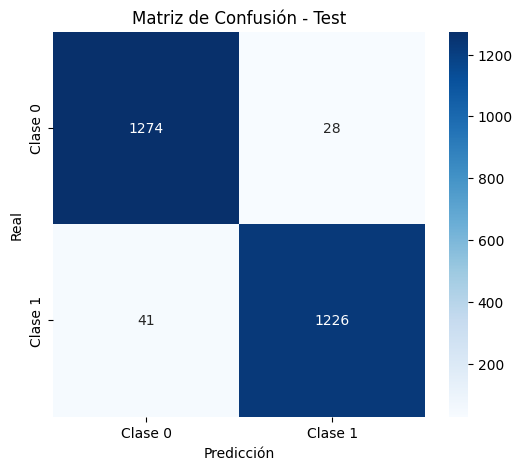

In [31]:
# Matriz de Confusión en Test
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Test')
plt.show()

- 1272 son los verdaderos negativos (TN): el modelo predijo correctamente la clase 0 (no recomendó el servicio) en 1272 casos.
- 1226 son los verdaderos positivos (TP): el modelo predijo correctamente la clase 1 (recomendó el servicio) en 1226 casos.
- 28 son los falsos positivos (FP): el modelo erróneamente predijo la clase 1 (recomendó el servicio) cuando la verdadera clase era 0 (no recomendó).
- 41 son los falsos negativos (FN): el modelo erróneamente predijo la clase 0 (no recomendó) cuando la verdadera clase era 1 (recomendó).

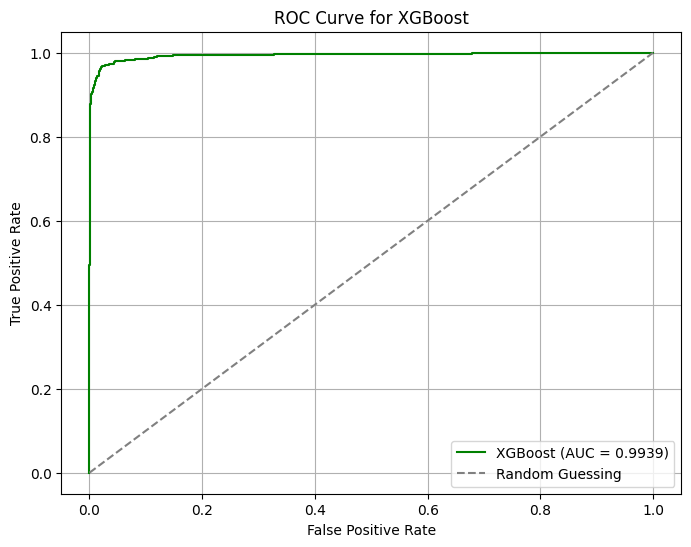

In [32]:
from sklearn.metrics import roc_curve

# Calcular la curva ROC para XGBoost
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, y_test_proba)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (AUC = {round(auc_xgbc, 4)})", color='green')

# Línea de referencia para clasificación aleatoria
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")

# Configuración del gráfico
plt.title("ROC Curve for XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Interpretación de Resultados

Los resultados del **modelo en Test** son muy buenos. La **precisión** y el **recall** son alrededor del 98% para la clase 1 y 97% para la clase 0, lo que indica que el modelo identifica correctamente la mayoría de los casos. El **F1-score** también es alto (97%), mostrando un buen balance entre precisión y recall.

El **AUC** en Test es 0.9939, lo que indica que el modelo tiene una excelente capacidad para distinguir entre las clases.

Los **resultados en Validación** son similares, con **precisión** y **recall** cerca del 98% y un **AUC** de 0.9942, lo que demuestra que el modelo generaliza bien en datos no vistos.

En **Train**, las métricas son ligeramente mejores, con **precisión** y **recall** de 98%, y un **AUC** de 0.9962, lo que refleja un excelente ajuste al conjunto de entrenamiento.

En general, el modelo presenta un rendimiento muy sólido con pocos errores, y parece estar bien ajustado para predecir tanto en datos de entrenamiento como en datos nuevos.

In [33]:
# Crear un DataFrame que incluya el target
data_with_target = X_train.copy()
data_with_target['target'] = y_train

# Calcular correlación de todas las características con el target
correlations = data_with_target.corr()['target'].sort_values(ascending=False)

# Mostrar las características más correlacionadas
print(correlations.head(10))  # Las 10 más correlacionadas
print(correlations.tail(10))  # Las 10 menos correlacionadas

target                1.000000
overall               0.916680
value_for_money       0.891850
cabin_service         0.791614
seat_comfort          0.757555
ground_service        0.697329
food_bev              0.588214
review_embedding_1    0.339396
airline_encoded       0.277602
review_embedding_0    0.200283
Name: target, dtype: float64
traveller_type_Family Leisure            -0.041887
continent_destin_North America           -0.059652
traveller_type_Couple Leisure            -0.074649
review_embedding_9                       -0.075367
country_origin_encoded                   -0.083710
airport_classification_origin_National   -0.084276
continent_origin_North America           -0.107392
cabin_Economy Class                      -0.203915
flight_year                              -0.264505
review_year                              -0.265489
Name: target, dtype: float64


In [35]:
# Obtén la importancia de las variables
importance = best_model.get_booster().get_score(importance_type='weight')

# Convierte a un DataFrame para ordenarlas
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                           Feature  Importance
0                          overall       101.0
13                 value_for_money        63.0
36              review_embedding_4        38.0
9                    cabin_service        36.0
33              review_embedding_1        34.0
12                  ground_service        28.0
35              review_embedding_3        27.0
38              review_embedding_6        25.0
8                     seat_comfort        24.0
39              review_embedding_7        22.0
25                 airline_encoded        20.0
32              review_embedding_0        17.0
40              review_embedding_8        17.0
14                  route_distance        17.0
37              review_embedding_5        16.0
26        iata_code_origin_encoded        15.0
27   iata_code_destination_encoded        14.0
15              route_time_minutes        13.0
28     municipality_origin_encoded        12.0
41              review_embedding_9        12.0
3            

In [36]:
# Supongamos que ya tienes entrenado tu modelo XGBoost como `xgb_model`
# Si no, asegúrate de entrenarlo primero.

# Obtener las importancias de las variables
gain_importance = best_model.get_booster().get_score(importance_type='gain')
cover_importance = best_model.get_booster().get_score(importance_type='cover')

# Convertir las importancias a un DataFrame
import pandas as pd
importance_comparison = pd.DataFrame({
    'Feature': list(gain_importance.keys()),
    'Gain': list(gain_importance.values()),
    'Cover': [cover_importance.get(key, 0) for key in gain_importance.keys()]  # Si no está, asigna 0
})

# Ordenar por Gain o Cover
importance_comparison = importance_comparison.sort_values(by='Gain', ascending=False)

# Mostrar los resultados
print(importance_comparison.head(10))  # Muestra las 10 variables más impor


                           Feature        Gain       Cover
13                 value_for_money  227.406647  373.864594
0                          overall  216.786667  383.588684
9                    cabin_service  133.433167  338.269409
12                  ground_service  105.548897  385.149170
11                        food_bev   61.281414  341.159729
6                      flight_year   45.225746  168.488007
8                     seat_comfort   26.054232  296.986664
10                    food_service    7.000984  165.408737
3                      review_year    5.652628  113.099464
22  continent_origin_North America    4.860654  112.940285


La variable overall es la más importante porque fue utilizada más veces (101) para hacer divisiones.

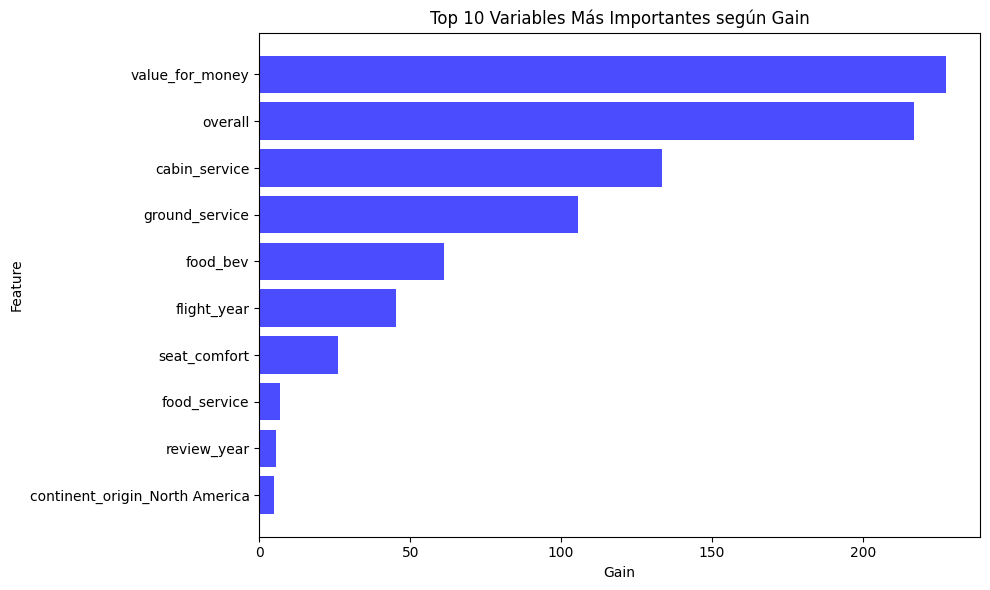

In [38]:
# Ordenar por Gain y seleccionar las 10 más importantes
top_10_features = importance_comparison.sort_values(by='Gain', ascending=False).head(10)

# Gráfico horizontal de las 10 variables más importantes
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Gain'], color='blue', alpha=0.7)

# Etiquetas y título
plt.xlabel('Gain')
plt.ylabel('Feature')
plt.title('Top 10 Variables Más Importantes según Gain')
plt.gca().invert_yaxis()  # Invertir el orden para que la más importante esté arriba
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Se observa como las variables cuantitativas representan bien si recomiendan o no.

## Comparación de Resultados

In [39]:
print("\nRegresión Logística - Accuracy:", round(accuracy_logreg, 4))
print("Regresión Logística - Precision:", round(precision_logreg, 4))
print("Regresión Logística - Recall:", round(recall_logreg, 4))
print("Regresión Logística - F1 Score:", round(f1_logreg, 4))
print("Regresión Logística - AUC:", round(auc_logreg, 4))
print("_________________________________________________________\n")
print("\nXGBoost - Accuracy:", round(accuracy_xgbc, 4))
print("XGBoost - Precision:", round(precision_xgbc, 4))
print("XGBoost - Recall:", round(recall_xgbc, 4))
print("XGBoost - F1 Score:", round(f1_xgbc, 4))
print("XGBoost - AUC:", round(auc_xgbc, 4))
print("_________________________________________________________\n")


Regresión Logística - Accuracy: 0.9708
Regresión Logística - Precision: 0.9753
Regresión Logística - Recall: 0.9653
Regresión Logística - F1 Score: 0.9702
Regresión Logística - AUC: 0.9707
_________________________________________________________


XGBoost - Accuracy: 0.9731
XGBoost - Precision: 0.9777
XGBoost - Recall: 0.9676
XGBoost - F1 Score: 0.9726
XGBoost - AUC: 0.9939
_________________________________________________________



Los resultados obtenidos muestran una diferencia significativa en AUC (de 0.9707 en Regresión Logística a 0.9937 en XGBoost), mientras que la diferencia en accuracy es pequeña (0.9708 en Regresión Logística y 0.9724 en XGBoost). Esto significa que XGBoost tiene un rendimiento mejor en la capacidad de distinguir entre las clases (especialmente en la separación de clases positivas y negativas), aunque ambos modelos tienen un rendimiento similar en términos de precisión general (accuracy).
